Converting matlab code to python

In [ ]:
import numpy as np
from scipy.stats import chi2
import time
import numpy as np
import uuid
import datetime
from scipy.optimize import least_squares
from scipy.stats import chi2
from scipy.sparse import vstack
import matplotlib.pyplot as plt
import math

In [ ]:
def gnc_weights_update(weights, mu, residuals, barc2):
    # GNC weights update for the TLS cost function
    th1 = (mu+1)/mu * barc2
    th2 = (mu)/(mu+1) * barc2  # th1 > th2
    for k in range(len(residuals)):
        if residuals[k] - th1 >= 0:
            weights[k] = 0
        elif residuals[k] - th2 <= 0:
            weights[k] = 1
        else:
            weights[k] = np.sqrt( barc2*mu*(mu+1)/residuals[k] ) - mu
    return weights, th1, th2

In [ ]:
def rand_in(n, m, interval):
    a = interval[0]
    b = interval[1]
    r = a + (b-a)*np.random.rand(n,m)
    return r

In [ ]:
def randn_in(n, m, interval):
    a = interval[0]
    b = interval[1]
    r = a + (b-a)*np.random.randn(n, m)
    return r

In [ ]:
def random_matrix(n, m, desired_rank=None):
    max_rank = min(n, m)
    if desired_rank is None:
        desired_rank = max_rank

    M = 3*np.random.rand(n, m)
    while np.linalg.matrix_rank(M) < max_rank and np.linalg.matrix_rank(M) > 0:
        M = randn_in(n, m, [-1, 1])

    rank_M = np.linalg.matrix_rank(M)
    if rank_M != desired_rank:
        col_perm = np.random.permutation(m)[:(rank_M - desired_rank + 1)]
        for i in range(1, rank_M - desired_rank + 1):
            M[:,col_perm[0]] = M[:,col_perm[i]]
    return M  

In [ ]:
def linear_regression_problem(N, outliers_percentage, **kwargs):
    #Just using defaults from matlab code
    x_dim = 3
    x_mean = 1
    x_std = 1
    y_dim = 3
    noise_std = 0.1
    outliers_low = -100
    outliers_high = 100

    if outliers_percentage is None:
        outliers_percentage = 0
    
    #Init of Linear Regression Problem
    problem = {'N': N, 'StateDimension': x_dim, 'MeasurementDimension': y_dim, 'MeasurementNoiseStd': noise_std, 'dof': y_dim, 'type': 'linear-estimation'}

    # x vector, randomly generated
    problem['x_gt'] = np.random.normal(x_mean, x_std, (x_dim, 1))

    # A Matrix, randomly generated for each y
    problem['A'] = []
    for i in range(problem['N']):
        problem['A'].append(random_matrix(y_dim, x_dim, min([x_dim, y_dim])))

    # y Measurements
    problem['y'] = []
    for i in range(problem['N']):
        problem['y'].append(problem['A'][i] @ problem['x_gt'] + np.random.normal(0, noise_std, (y_dim, 1)))
    
    # Add outliers
    num_outliers = int(np.floor(outliers_percentage * N))
    convi = 1 / noise_std * np.eye(y_dim)
    problem['outliers'] = np.sort(np.random.choice(problem['N'], num_outliers, replace=False))
    # problem['outliers'] = np.sort(np.random.permutation(problem['N'])[:num_outliers])

    for i in problem['outliers']:
        y_gt = problem['y'][i]
        d = 0
        while d < chi2.ppf(0.999, y_dim):
            y_meas = rand_in(y_dim, 1, [outliers_low, outliers_high])
            d = (y_gt - y_meas).T @ convi @ (y_gt - y_meas)
        problem['y'][i] = y_meas

    return problem

In [ ]:
def gnc(problem, f, **kwargs):
    params = {'ContinuationFactor': 1.4,
              'InitialMu': 'auto',
              'NoiseBound': 0,
              'MaxIterations': int(1e3),
              'CostThreshold': 0}
    params.update(kwargs)

    max_iterations = params['MaxIterations']

    _, f_info = f(problem)

    barc2 = params['NoiseBound']
    weights = np.ones(problem["N"])
    if isinstance(params['InitialMu'], str) and params['InitialMu'].lower() == 'auto':
        mu = barc2 / (2 * np.max(f_info['residuals'].T) - barc2)
    else:
        mu = params['InitialMu']
    
    info_init = f_info
    prev_f_cost = 0

    i = 0

    while i < max_iterations:
        weights, _, _ = gnc_weights_update(weights, mu, f_info["residuals"], barc2)
        _, f_info = f(problem, weights)
        f_cost = np.sum(f_info["residuals"][:].T @ weights)
        cost_diff = abs(f_cost - prev_f_cost)
        prev_f_cost = f_cost
        
        if (cost_diff <= params["CostThreshold"]):
          break
        mu = mu * params["ContinuationFactor"]
        i = i + 1

    inliers = np.where(weights > 1-np.finfo(float).eps)[0]    

    return inliers, f_info, info_init

In [ ]:
def leastSquareNorm2(problem, weights=None, **kwargs):
    measurements = np.arange(problem["N"])
    default_weights = np.ones(problem["N"])

    inliers = measurements.astype(int)
    if weights is None:
      w = default_weights
    else:
      w = weights

    # Build weighted matrices
    A_ = []
    for i in inliers:
        A_.append(np.sqrt(w[i]) * problem["A"][i])
    A_ = np.vstack(A_)
    y_ = []
    for i in inliers:
        y_.append(np.sqrt(w[i]) * problem["y"][i])
    y_ = np.vstack(y_)

    if 'Estimate' not in kwargs:
        x = np.linalg.lstsq(A_, y_, rcond=None)[0]
    else:
        x = kwargs['Estimate']
    f_val = np.linalg.norm(A_.dot(x) - y_)**2

    # Residues
    residues = np.zeros((problem["MeasurementDimension"], problem["N"]))
    for i in range(problem["N"]):
        residues[:,i] = (problem["A"][i].dot(x) - problem["y"][i]).reshape((problem["MeasurementDimension"],))
    # Residuals
    residuals = np.zeros(problem["N"])
    for i in range(problem["N"]):
        residuals[i] = np.linalg.norm(residues[:,i])**2
    info = {'x': x, 'residuals': residuals, 'residues': residues}
    return f_val, info

In [ ]:
def detectionStats(problem, inliers):
  num_outliers = len(problem['outliers'])
  if num_outliers == 0:
      true_positive_rate = 1
      false_positive_rate = 0
      precision = 1
      recall = 1
  else:
      outliers = set(range(1, problem['N']+1)) - set(inliers)
      true_inliers = set(range(1, problem['N']+1)) - set(problem['outliers'])
      true_positive = set(problem['outliers']) & outliers
      false_positive = true_inliers & outliers
      true_positive_rate = len(true_positive)/num_outliers
      false_positive_rate = len(false_positive)/len(true_inliers)
      precision = len(true_positive) / (len(true_positive) + len(false_positive))
      recall = len(true_positive)/num_outliers
  return true_positive_rate, false_positive_rate, precision, recall


In [ ]:
problem_100_80 = linear_regression_problem(100, 0.8)
problem_200_80 = linear_regression_problem(200, 0.8)
problem_50_80 = linear_regression_problem(50, 0.8)
problem_100_50 = linear_regression_problem(100, 0.5)
problem_100_20 = linear_regression_problem(100, 0.2)

In [ ]:
epsilon_100_80 = chi2.ppf(0.99, problem_100_80['dof']) * problem_100_80['MeasurementNoiseStd']**2
epsilon_200_80 = chi2.ppf(0.99, problem_200_80['dof']) * problem_200_80['MeasurementNoiseStd']**2
epsilon_50_80 = chi2.ppf(0.99, problem_50_80['dof']) * problem_50_80['MeasurementNoiseStd']**2
epsilon_100_50 = chi2.ppf(0.99, problem_100_50['dof']) * problem_100_50['MeasurementNoiseStd']**2
epsilon_100_20 = chi2.ppf(0.99, problem_100_20['dof']) * problem_100_20['MeasurementNoiseStd']**2

In [ ]:
inliers_100_80, info_100_80, info_init_100_80 = gnc(problem_100_80, leastSquareNorm2, NoiseBound=epsilon_100_80)
inliers_200_80, info_200_80, info_init_200_80 = gnc(problem_200_80, leastSquareNorm2, NoiseBound=epsilon_200_80)
inliers_50_80, info_50_80, info_init_50_80 = gnc(problem_50_80, leastSquareNorm2, NoiseBound=epsilon_50_80)
inliers_100_50, info_100_50, info_init_100_50 = gnc(problem_100_50, leastSquareNorm2, NoiseBound=epsilon_100_50)
inliers_100_20, info_100_20, info_init_100_20 = gnc(problem_100_20, leastSquareNorm2, NoiseBound=epsilon_100_20)

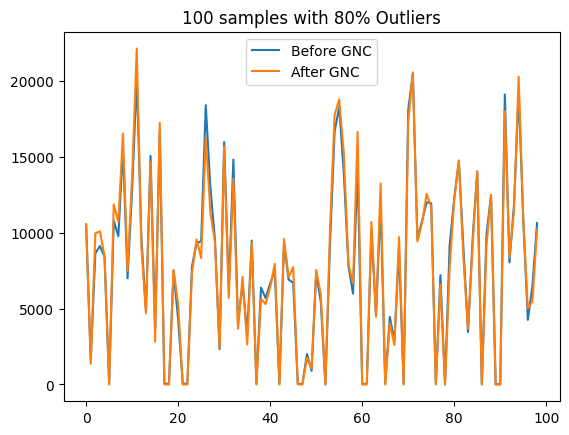

In [ ]:
plt.plot(info_init_100_80["residuals"][:-1], label = "Before GNC");
plt.plot(info_100_80["residuals"][:-1], label = "After GNC");
plt.title("100 samples with 80% Outliers")
plt.legend(); 

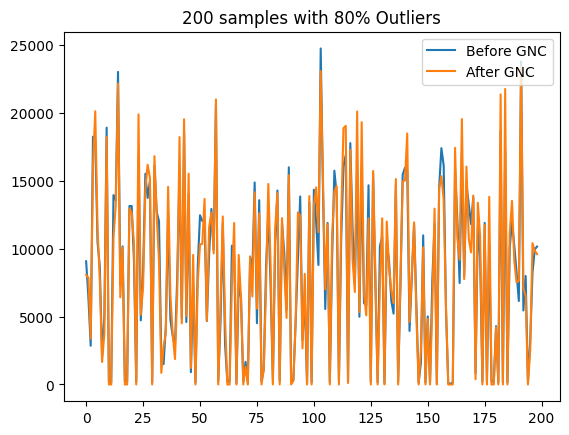

In [ ]:
plt.plot(info_init_200_80["residuals"][:-1], label = "Before GNC");
plt.plot(info_200_80["residuals"][:-1], label = "After GNC");
plt.title("200 samples with 80% Outliers")
plt.legend(); 

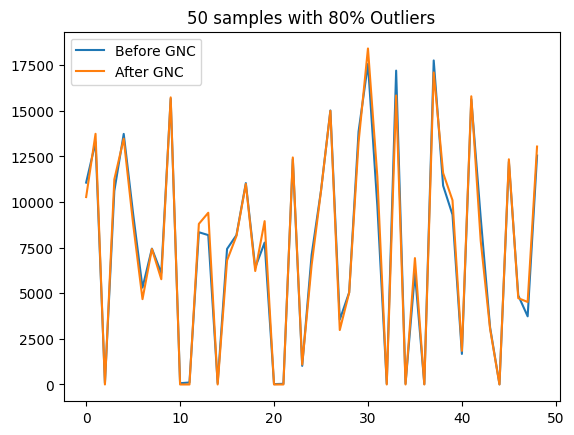

In [ ]:
plt.plot(info_init_50_80["residuals"][:-1], label = "Before GNC");
plt.plot(info_50_80["residuals"][:-1], label = "After GNC");
plt.title("50 samples with 80% Outliers")
plt.legend(); 

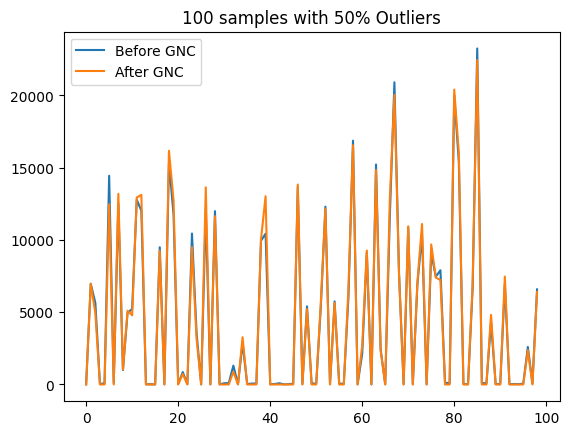

In [ ]:
plt.plot(info_init_100_50["residuals"][:-1], label = "Before GNC");
plt.plot(info_100_50["residuals"][:-1], label = "After GNC");
plt.title("100 samples with 50% Outliers")
plt.legend(); 

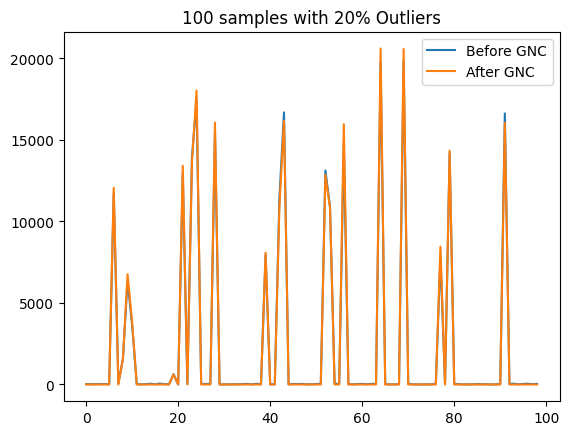

In [ ]:
plt.plot(info_init_100_20["residuals"][:-1], label = "Before GNC");
plt.plot(info_100_20["residuals"][:-1], label = "After GNC");
plt.title("100 samples with 20% Outliers")
plt.legend(); 

In [ ]:
tpr_100_80, fpr_100_80, prec_100_80, rec_100_80 = detectionStats(problem_100_80, inliers_100_80)
tpr_200_80, fpr_200_80, prec_200_80, rec_200_80 = detectionStats(problem_200_80, inliers_200_80)
tpr_50_80, fpr_50_80, prec_50_80, rec_50_80 = detectionStats(problem_50_80, inliers_50_80)
tpr_100_50, fpr_100_50, prec_100_50, rec_100_50 = detectionStats(problem_100_50, inliers_100_50)
tpr_100_20, fpr_100_20, prec_100_20, rec_100_20 = detectionStats(problem_100_20, inliers_100_20)

In [ ]:
tpr_outliers_diff = [tpr_100_20, tpr_100_50, tpr_100_80]
tpr_number_diff = [tpr_50_80, tpr_100_80, tpr_200_80]
fpr_outliers_diff = [fpr_100_20, fpr_100_50, fpr_100_80]
fpr_number_diff = [fpr_50_80, fpr_100_80, fpr_200_80]
prec_outliers_diff = [prec_100_20, prec_100_50, prec_100_80]
prec_number_diff = [prec_50_80, prec_100_80, prec_200_80]
rec_outliers_diff = [rec_100_20, rec_100_50, rec_100_80]
rec_number_diff = [rec_50_80, rec_100_80, rec_200_80]
x_index = [1, 2, 3]

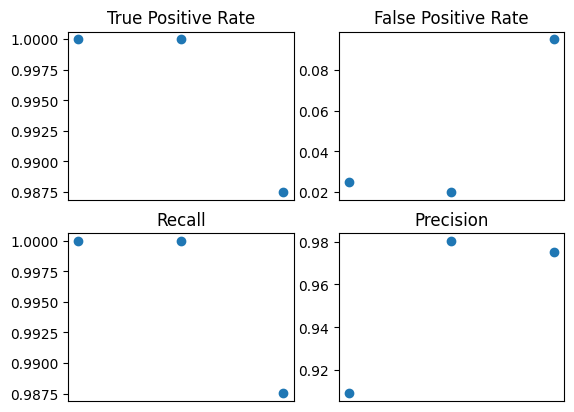

In [ ]:
fig, ax = plt.subplots(2,2)
ax[0][0].scatter(x_index, tpr_outliers_diff);
ax[0][0].set_title("True Positive Rate");
ax[0][1].scatter(x_index, fpr_outliers_diff);
ax[0][1].set_title("False Positive Rate");
ax[1][1].scatter(x_index, prec_outliers_diff);
ax[1][1].set_title("Precision");
ax[1][0].scatter(x_index, rec_outliers_diff);
ax[1][0].set_title("Recall");
ax[0][0].xaxis.set_visible(False)
ax[0][1].xaxis.set_visible(False)
ax[1][0].xaxis.set_visible(False)
ax[1][1].xaxis.set_visible(False)


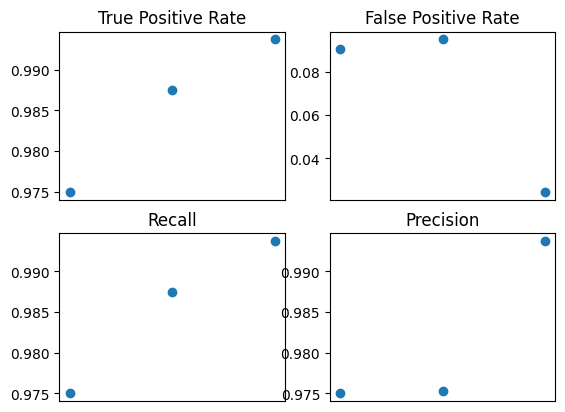

In [ ]:
fig, ax = plt.subplots(2,2)
ax[0][0].scatter(x_index, tpr_number_diff);
ax[0][0].set_title("True Positive Rate");
ax[0][1].scatter(x_index, fpr_number_diff);
ax[0][1].set_title("False Positive Rate");
ax[1][1].scatter(x_index, prec_number_diff);
ax[1][1].set_title("Precision");
ax[1][0].scatter(x_index, rec_number_diff);
ax[1][0].set_title("Recall");
ax[0][0].xaxis.set_visible(False)
ax[0][1].xaxis.set_visible(False)
ax[1][0].xaxis.set_visible(False)
ax[1][1].xaxis.set_visible(False)